### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.optimizers import Adam

### Dataset information
* Product Name
* Rent Price
* Product Photo
* Renters
* Description

In [2]:
dataset = pd.read_csv('../data/rentby_dataset.csv')
dataset.head()

,id,product_name,rent_price,url_photo,link,renters,description,cosplay,hiking,product_id,rating
0,0,Celana Tactical Original Big Size Cargo Pria H...,16900,https://images.tokopedia.net/img/cache/500-squ...,https://ta.tokopedia.com/promo/v1/clicks/8a-xg...,Injection Project,Celana Tactical Original Big Size Cargo Pria H...,0,1,091def81-8550-44c2-8a6c-9aa32722ec77,4.8
1,1,Celana Cargo Tactical Panjang Pria HPR Jumbo B...,16500,https://images.tokopedia.net/img/cache/500-squ...,https://ta.tokopedia.com/promo/v1/clicks/8a-xg...,Injection Project,"Keunggulan Produk Kami : - Eksklusif, - Tampil...",0,1,5d29477f-ea1c-41f1-960f-1f64d8531adb,4.6
2,2,Celana PDL Tactical Ripstop Original Termurah ...,7600,https://images.tokopedia.net/img/cache/500-squ...,https://ta.tokopedia.com/promo/v1/clicks/8a-xg...,Java Seven Store,* 1kg bisa 3pcs * Celana PDL Tactical Original...,0,1,638b1099-85dd-401c-8ded-08a4d54fdfe0,4.8
3,3,"CELANA PRIA TACTICAL CARGO PANJANG - Cream, 28",6000,https://images.tokopedia.net/img/cache/500-squ...,https://ta.tokopedia.com/promo/v1/clicks/8a-xg...,mytactical_1,BIG PROMO!!! PENTING!!! √ Jangan ragukan kuali...,0,1,521496ac-296f-4a9a-be41-1c43ef1488c3,4.0
4,4,Celana Tactical M-Tac Model Terbaru/Cargo/Pria...,10000,https://images.tokopedia.net/img/cache/500-squ...,https://ta.tokopedia.com/promo/v1/clicks/8a-xg...,naondstore,Assalamu'alaikum Wr. Wb. Selamat Datang ...,0,1,9e3939fb-0ccc-47c9-b0ab-6bf2777772aa,4.2


In [3]:
print("Number of records: ", dataset.shape[0])
print("Number of fields: ", dataset.shape[1])

Number of records:  9165
Number of fields:  11


### Display products names and preprocess them

In [4]:
dataset['product_name']

0       Celana Tactical Original Big Size Cargo Pria H...
1       Celana Cargo Tactical Panjang Pria HPR Jumbo B...
2       Celana PDL Tactical Ripstop Original Termurah ...
3          CELANA PRIA TACTICAL CARGO PANJANG - Cream, 28
4       Celana Tactical M-Tac Model Terbaru/Cargo/Pria...
                              ...                        
9160    ch1 2. King Rabbit Thermal Blanket Selimut Fle...
9161    Dunlopillo Hooded Thermal Blanket ( Selimut To...
9162    TERMURAH KING RABBIT THERMAL BLANKET SELIMUT F...
9163    NEW PRODUK KING RABBIT THERMAL BLANKET FLEECE ...
9164    dunlopillo thermal & travel blanket black seli...
Name: product_name, Length: 9165, dtype: object

Removing unwanted characters and words in product name

In [5]:
dataset['product_name'] = dataset['product_name'].apply(lambda x: x.replace(u'\xa0',u' '))
dataset['product_name'] = dataset['product_name'].apply(lambda x: x.replace('\u200a',' '))
dataset['product_name'] = dataset['product_name'].str.lower()
corpus = dataset['product_name']

### Callbacks

In [6]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.88):
            print("\nDesired value is already achieved!")
            self.model.stop_training = True

### Tokenization

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['product_name'])
total_words = len (tokenizer.word_index)+1

# n_gram sequence
def n_gram_seqs(corpus, tokenizer):

    input_sequences = []

    for line in corpus:
      token_list = tokenizer.texts_to_sequences([line])[0]
      for i in range(1,len(token_list)):
        n_gram_sequences = token_list[:i+1]
        input_sequences.append(n_gram_sequences)
    
    return input_sequences

input_sequences = n_gram_seqs(corpus, tokenizer)
max_sequence_len = max([len(x) for x in input_sequences])


### Padding

In [8]:
# function padded
def pad_seqs(input_sequences, maxlen):
    padded_sequences = pad_sequences(input_sequences, maxlen = maxlen)
    return padded_sequences

input_sequences = pad_seqs(input_sequences, max_sequence_len)
print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (78516, 39)


In [9]:
# feature and label
def features_and_labels(input_sequences, total_words):
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels,num_classes = total_words)
    return features, one_hot_labels

In [10]:
features, labels = features_and_labels(input_sequences, total_words)

### Model

In [23]:
def create_model(total_words, max_sequence_len):
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(total_words, activation="softmax"))
    adam = tf.keras.optimizers.Adam(learning_rate= 0.001)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam,
                  metrics=['accuracy'])
    return model

In [24]:
model = create_model(total_words, max_sequence_len)
history = model.fit(features, labels, callbacks=myCallback(), epochs=50, verbose=1)

Epoch 1/50
2454/2454 [==============================] - 187s 74ms/step - loss: 6.7132 - accuracy: 0.0770
Epoch 2/50
2454/2454 [==============================] - 141s 58ms/step - loss: 5.4103 - accuracy: 0.1642
Epoch 3/50
2454/2454 [==============================] - 135s 55ms/step - loss: 4.7017 - accuracy: 0.2157
Epoch 4/50
2454/2454 [==============================] - 136s 55ms/step - loss: 4.1694 - accuracy: 0.2606
Epoch 5/50
2454/2454 [==============================] - 137s 56ms/step - loss: 3.7288 - accuracy: 0.2994
Epoch 6/50
2454/2454 [==============================] - 137s 56ms/step - loss: 3.3533 - accuracy: 0.3385
Epoch 7/50
2454/2454 [==============================] - 205s 83ms/step - loss: 3.0262 - accuracy: 0.3806
Epoch 8/50
2454/2454 [==============================] - 210s 86ms/step - loss: 2.7373 - accuracy: 0.4260
Epoch 9/50
2454/2454 [==============================] - 202s 82ms/step - loss: 2.4810 - accuracy: 0.4675
Epoch 10/50
2454/2454 [==============================] 

### Predicting The Next Word for Search

In [31]:
# WORD PREDICTIONS

def generate_predicted_text(seed_text, model, tokenizer, max_sequence_len, num_predictions = 5, max_next_words = 2):
    predicted_texts = set()
    
    while len(predicted_texts) < num_predictions:
        current_seed = seed_text
        generated_text = current_seed
        
        for _ in range(max_next_words):
            token_list = tokenizer.texts_to_sequences([current_seed])[0]
            token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
            predicted_probs = model.predict(token_list, verbose=0)[0]
            predicted_class = np.random.choice(len(predicted_probs), p=predicted_probs)
            
            output_word = ""
            for word, index in tokenizer.word_index.items():
                if index == predicted_class:
                    output_word = word
                    break
            current_seed += " " + output_word
            generated_text += " " + output_word

        predicted_texts.add(generated_text)
    
    return list(predicted_texts)

### Predicting Reccomendation Arrays

In [32]:
# CONTENT_RECOMMENDATION

# embedding input
def get_embeddings(model, tokenizer, texts, max_sequence_len):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len-1)
    embeddings = model.predict(padded_sequences)
    return embeddings

product_embeddings = get_embeddings(model, tokenizer, dataset['product_name'], max_sequence_len)

# input comparison simmilarities
def recommend_products(user_input, model, tokenizer, product_embeddings, data, max_sequence_len):
    input_seq = tokenizer.texts_to_sequences([user_input])
    input_padded = pad_sequences(input_seq, maxlen=max_sequence_len-1)
    input_embedding = model.predict(input_padded)

    similarities = cosine_similarity(input_embedding, product_embeddings)
    similar_indices = similarities.argsort()[0][::-1]

    recommendations = data.iloc[similar_indices][['product_name', 'rent_price', 'url_photo', 'link']]
    return recommendations

287/287 [==============================] - 12s 43ms/step


In [33]:
tulis = "kostum" 
recommendations = recommend_products(tulis, model, tokenizer, product_embeddings, dataset, max_sequence_len)
print(recommendations)

1/1 [==============================] - 0s 34ms/step
                                           product_name  rent_price  \
4370  1920s flapper aksesoris gatsby costume aksesor...       73120   
7646  kani_id kostum cosplay anime takt op. destiny ...       52602   
5607  1set kostum halloween cosplay jubah halloween ...       21100   
7978  promo akhir tahun topeng venom costume mask mo...        6860   
7604  barang terlaris little red riding hood costume...       41100   
...                                                 ...         ...   
5264  a wetrose fuwawa abyssgard cosplay shoes costu...      144650   
7000  ' ?wetrose? fuwawa abyssgard cosplay shoes cos...      118350   
5265  . ?wetrose? fuwawa abyssgard cosplay shoes cos...      118350   
5262  ?wetrose? fuwawa abyssgard cosplay shoes costu...      144600   
7882  jubah topeng pj maskers catboydkk owlettedkk g...        9000   

                                              url_photo  \
4370  https://images.tokopedia.net/i

### Plotting model accuracy and loss

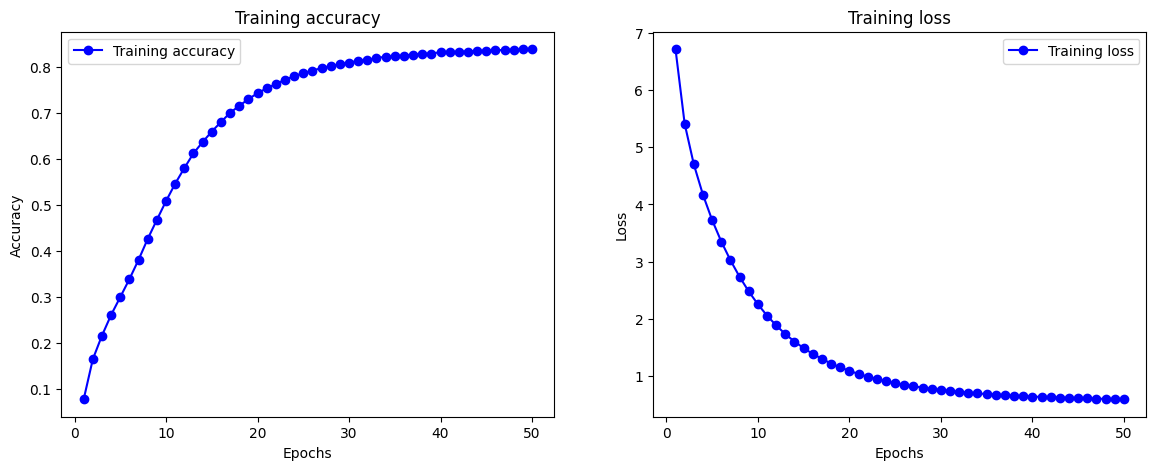

In [34]:
def plot_metrics(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.title('Training accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [28]:
import time
saved_model_path = "./{}.h5".format(int(time.time()))

model.save(saved_model_path)

In [29]:
%pip install tensorflowjs

  Using cached tensorflowjs-4.20.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached flax-0.7.2-py3-none-any.whl.metadata (10.0 kB)
  Using cached jax-0.4.13.tar.gz (1.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
INFO: pip is looking at multiple versions of tensorflowjs to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorflowjs-4.19.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached tensorflowjs-4.18.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached tensorflowjs-4.17.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached tensorflowjs-4.16.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached tensorflowjs-4.15.0-py3-none-any.whl.metadata (3.2 k

ERROR: Cannot install flax because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [ ]:
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

In [ ]:
!zip model.zip *.bin model.json